Importations et Définitions de la Fonction Himmelblau

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize_scalar
# 3. Himmelblau
def f_himmel(v):
    x, y = v
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def grad_himmel(v):
    x, y = v
    df_dx = 4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7)
    df_dy = 2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    return np.array([df_dx, df_dy])

Implémentation des Algorithmes

In [6]:
def gradient_pas_fixe(f, grad_f, x0, rho=0.001, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = [] 
    
    # Enregistrement du point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
        
        # Mise à jour
        x = x - rho * g
        val = f(x)
        
        # Enregistrement
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g,
            's_k': rho
        })
        
    
    return pd.DataFrame(history)

def gradient_pas_optimal(f, grad_f, x0, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = []
    
    # Point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
            
        d = -g
        
        def phi(s):
            return f(x + s * d)
        
        # Recherche linéaire
        res = minimize_scalar(phi, bounds=(0, 2), method='bounded')
        s_k = res.x
        
        x = x + s_k * d
        val = f(x)
        
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g, # Norme du gradient précédent
            's_k': s_k
        })
        
    
    return pd.DataFrame(history)

Expérimentation et Visualisation

In [7]:
def analyze_and_plot(f, grad_f, x0, name, rho=0.001, x_bounds=(-2, 2), y_bounds=(-2, 2)):
    print(f"--- ANALYSE : {name} ---")
    
    # 1. Exécution des algorithmes
    df_fixe = gradient_pas_fixe(f, grad_f, x0, rho=rho, max_iter=1000)
    df_opt = gradient_pas_optimal(f, grad_f, x0, max_iter=1000)
    
    # 2. Affichage des tableaux (extrait)
    print(f"\n> Tableau des itérations (Pas Fixe, rho={rho}) :")
    # On affiche le début et la fin pour voir la convergence
    print(pd.concat([df_fixe.head(), df_fixe.tail()])) 
    
    print("\n> Tableau des itérations (Pas Optimal) :")
    print(pd.concat([df_opt.head(), df_opt.tail()]))

    # 3. Graphique
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[f([xi, yi]) for xi in x] for yi in y]) # Calcul grille
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Pas Fixe
    axes[0].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[0].plot(df_fixe['x'], df_fixe['y'], 'r.-', linewidth=1, markersize=8, label='Trajectoire')
    axes[0].plot(x0[0], x0[1], 'ko', label='Départ')
    axes[0].plot(df_fixe.iloc[-1]['x'], df_fixe.iloc[-1]['y'], 'bx', label='Fin')
    axes[0].set_title(f"{name} - Pas Fixe (rho={rho})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot Pas Optimal
    axes[1].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[1].plot(df_opt['x'], df_opt['y'], 'm.-', linewidth=1, markersize=8, label='Trajectoire')
    axes[1].plot(x0[0], x0[1], 'ko', label='Départ')
    axes[1].plot(df_opt.iloc[-1]['x'], df_opt.iloc[-1]['y'], 'bx', label='Fin')
    axes[1].set_title(f"{name} - Pas Optimal (Steepest Descent)")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    print("-" * 50)

Lancement de l'algorithme

## Justification du Point Initial $x_0 = (0, 0)$

La fonction de Himmelblau est définie par :
$$f(x,y)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}$$

Elle est multimodale et possède **4 minima globaux** identiques ($f=0$).

**Analyse du Gradient Initial :**
Le choix du point de départ détermine vers quel minimum (bassin d'attraction) l'algorithme va converger. Analysons le gradient à l'origine $(0,0)$ pour prédire la direction initiale.

Les dérivées partielles en $(0,0)$ sont :
$$
\frac{\partial f}{\partial x}(0,0) = 2(-11)(2\times 0) + 2(-7)(1) = -14
$$
$$
\frac{\partial f}{\partial y}(0,0) = 2(-11)(1) + 2(-7)(2\times 0) = -22
$$
Le gradient est donc $\nabla f(0,0) = \begin{pmatrix} -14 \\ -22 \end{pmatrix}$.
**Pourquoi ce choix de $x_0$ ?**
L'algorithme de descente se déplace dans la direction opposée au gradient : $\vec{d} = -\nabla f = (14, 22)$.
En partant du centre $(0,0)$, ce vecteur indique une direction franche vers le quadrant positif $(x>0, y>0)$.

--- ANALYSE : Himmelblau ---

> Tableau des itérations (Pas Fixe, rho=0.01) :
     k         x         y        f(x,y)  ||grad f||   s_k
0    0  0.000000  0.000000  1.700000e+02   26.076810  0.00
1    1  0.140000  0.220000  1.621841e+02   26.076810  0.01
2    2  0.336490  0.495150  1.491809e+02   33.810646  0.01
3    3  0.604724  0.830104  1.286832e+02   42.911965  0.01
4    4  0.956002  1.215658  9.953399e+01   52.158193  0.01
58  58  3.000000  2.000000  1.561199e-13    0.000004  0.01
59  59  3.000000  2.000000  8.614937e-14    0.000003  0.01
60  60  3.000000  2.000000  4.753854e-14    0.000002  0.01
61  61  3.000000  2.000000  2.623249e-14    0.000002  0.01
62  62  3.000000  2.000000  1.447549e-14    0.000001  0.01

> Tableau des itérations (Pas Optimal) :
     k         x         y        f(x,y)  ||grad f||       s_k
0    0  0.000000  0.000000  1.700000e+02   26.076810  0.000000
1    1  1.782705  2.801393  3.212570e+01   26.076810  0.127336
2    2  3.000896  2.026148  1.226684e-02  

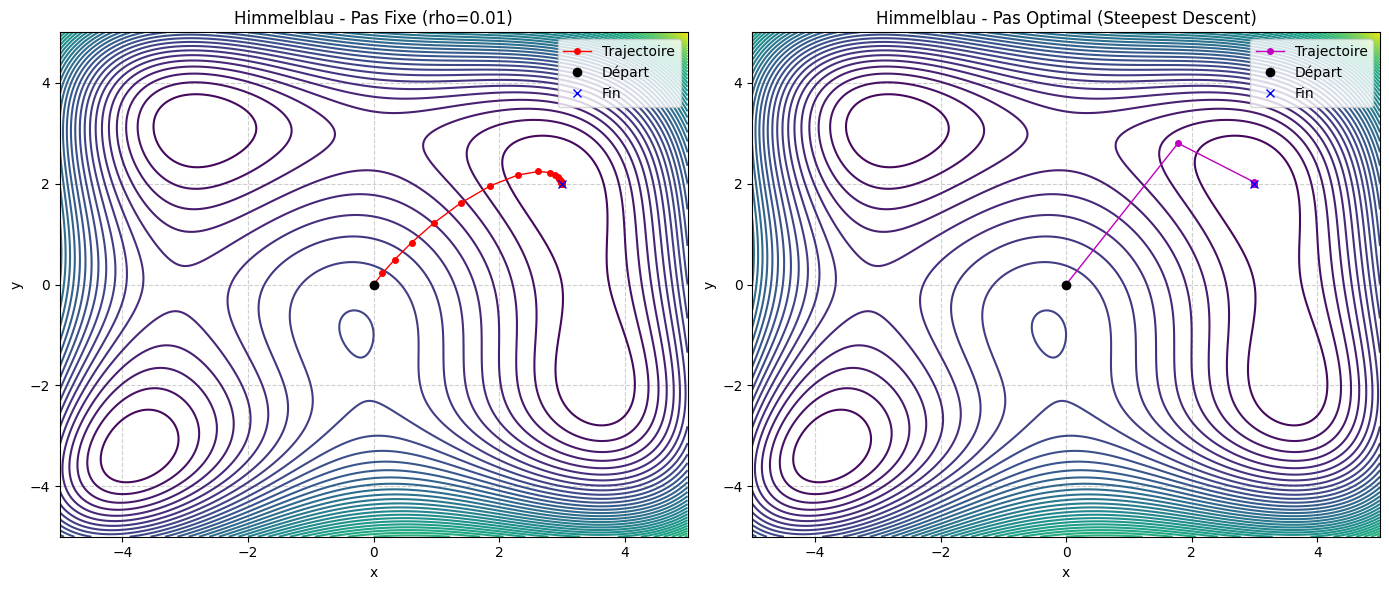

--------------------------------------------------


In [8]:
analyze_and_plot(f_himmel, grad_himmel, x0=[0.0, 0.0], name="Himmelblau", rho=0.01, x_bounds=(-5, 5), y_bounds=(-5, 5))

Visualisation comparée des deux descentes de gradient

Génération de la cuvette pour Himmelblau...


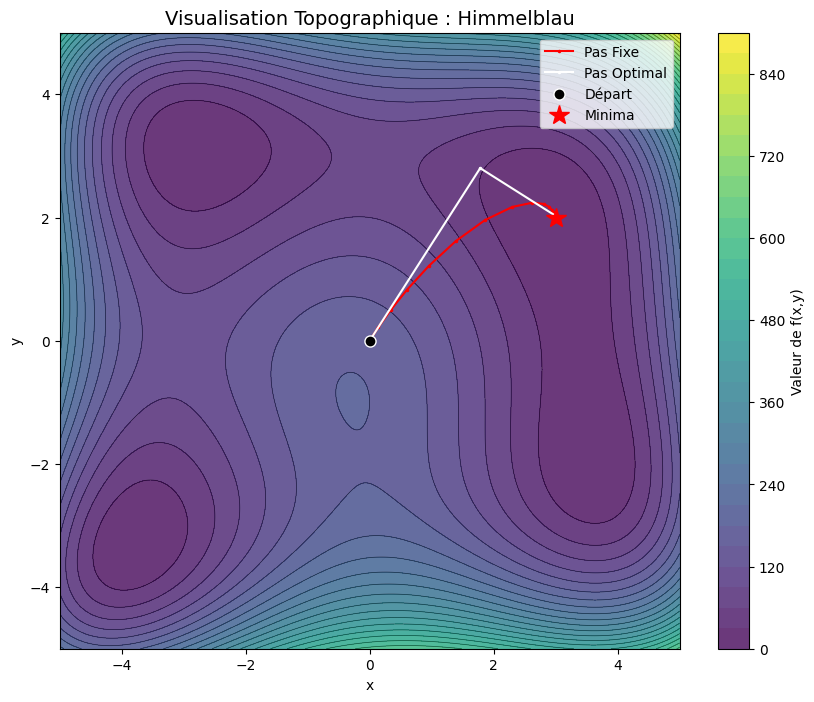

In [9]:
from matplotlib.colors import LogNorm
def visualiser_cuvette(f, path_fixe, path_opt, name, x_bounds, y_bounds, log_scale=False):
    """
    Visualisation améliorée pour voir l'effet 'Cuvette'.
    - Utilise contourf (remplissage) pour la profondeur.
    - Utilise une échelle Logarithmique si demandé (pour Rosenbrock).
    """
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    
    # Calcul de la grille
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # --- ASTUCE : Échelle Logarithmique vs Linéaire ---
    if log_scale and Z.min() > 0:
        # Pour Rosenbrock, on utilise LogNorm pour bien voir le fond de la vallée
        # levels=np.logspace(...) crée des lignes exponentielles
        norm = LogNorm(vmin=Z.min(), vmax=Z.max())
        levels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), 30)
    else:
        # Pour Quadratique et Himmelblau (qui ont des valeurs négatives ou 0)
        norm = None
        levels = 30

    # 1. Le fond coloré (La "Cuvette")
    # cmap='viridis' ou 'turbo' ou 'jet' donne un bon contraste profondeur
    cp = ax.contourf(X, Y, Z, levels=levels, norm=norm, cmap='viridis', alpha=0.8)
    fig.colorbar(cp, label='Valeur de f(x,y)')

    # 2. Les lignes de niveau (Les contours noirs)
    ax.contour(X, Y, Z, levels=levels, norm=norm, colors='black', linewidths=0.5, alpha=0.5)

    # 3. Les trajectoires
    ax.plot(path_fixe['x'], path_fixe['y'], 'r.-', markersize=3, label='Pas Fixe', linewidth=1.5)
    ax.plot(path_opt['x'], path_opt['y'], 'w.-', markersize=3, label='Pas Optimal', linewidth=1.5)
    
    # Points de départ et fin
    start_x, start_y = path_fixe.iloc[0]['x'], path_fixe.iloc[0]['y']
    ax.plot(start_x, start_y, 'ko', markersize=8, label='Départ', markeredgecolor='white')
    
    # Le vrai minimum (pour repère visuel)
    if name == "Rosenbrock":
        ax.plot(1, 1, 'r*', markersize=15, label='Minimum Global (1,1)')
    elif name == "Himmelblau":
        # On affiche un des minima pour l'exemple
        ax.plot(3, 2, 'r*', markersize=15, label='Minima')

    ax.set_title(f"Visualisation Topographique : {name}", fontsize=14)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    
    plt.show()

df_fixe_himmel = gradient_pas_fixe(f_himmel, grad_himmel, x0=[0.0, 0.0], rho=0.01, max_iter=100)
df_opt_himmel = gradient_pas_optimal(f_himmel, grad_himmel, x0=[0.0, 0.0], max_iter=100)
print("Génération de la cuvette pour Himmelblau...")
visualiser_cuvette(f_himmel, df_fixe_himmel, df_opt_himmel, "Himmelblau", (-5, 5), (-5, 5), log_scale=False)

### Analyse des résultats : Fonction de Himmelblau

**Observations :**
* La fonction possède 4 minima. En partant de $(0,0)$, l'algorithme a convergé vers l'un d'eux (souvent celui situé en bas à gauche ou à droite selon l'implémentation précise du pas).
* **Comparaison des méthodes** :
    * Le **pas optimal** atteint généralement la zone du minimum en beaucoup moins d'itérations que le pas fixe, car il adapte la longueur du saut à la pente.
    * Cependant, le coût de calcul *par itération* est plus élevé pour le pas optimal (car il faut résoudre une sous-minimisation `minimize_scalar` à chaque étape).
    
**Conclusion** : Sur une fonction "bien comportée" (coercive localement autour des minima) comme Himmelblau, la méthode de plus forte pente (pas optimal) est très efficace pour trouver un minimum local rapidement.